# Simple TensorFlow Haskell Demo
* Based on the example at https://github.com/tensorflow/haskell
* (Requires following the install steps for tensorflow haskell first.)

In [11]:
import qualified TensorFlow.Core as TF
import qualified TensorFlow.GenOps.Core as TF
import qualified TensorFlow.Gradient as TF
import qualified TensorFlow.Ops as TF
import Control.Monad (replicateM, replicateM_, zipWithM)
import System.Random (randomIO)



In [8]:
gradientDescent :: Float
                -> TF.Tensor TF.Build Float
                -> [TF.Tensor TF.Ref Float]
                -> TF.Session TF.ControlNode
gradientDescent alpha loss params = do
    let applyGrad param grad =
            TF.assign param (param `TF.sub` (TF.scalar alpha `TF.mul` grad))
    TF.group =<< zipWithM applyGrad params =<< TF.gradients loss params

In [9]:
fit :: [Float] -> [Float] -> IO (Float, Float)
fit xData yData = TF.runSession $ do
    -- Create tensorflow constants for x and y.
    let x = TF.vector xData
        y = TF.vector yData
    -- Create scalar variables for slope and intercept.
    w <- TF.initializedVariable 0
    b <- TF.initializedVariable 0
    -- Define the loss function.
    let yHat = (x `TF.mul` w) `TF.add` b
        loss = TF.square (yHat `TF.sub` y)
    -- Optimize with gradient descent.
    let learningRate = 0.01
        iterations = 400
    trainStep <- gradientDescent learningRate loss [w, b]
    replicateM_ iterations (TF.run trainStep)
    -- Return the learned parameters.
    (TF.Scalar w', TF.Scalar b') <- TF.run (w, b)
    return (w', b')

In [10]:
pointsCount = 30
slope = -5
intercept = 11

In [16]:
:ext ScopedTypeVariables
-- Generate data where `y = x*slope + intercept`.
xData :: [Float] <- replicateM pointsCount randomIO
let yData = [x*slope + intercept | x <- xData]
    minX = min xData
    maxX = max xData

-- Add some noise to y values
yNoiseData :: [Float] <- replicateM pointsCount randomIO
let noiseScale = 0.5
    noisyY = zipWith (+) yData (map (*noiseScale) yNoiseData)
(w, b) <- fit xData noisyY

In [19]:
(w, b)

(-5.0135417,11.274192)

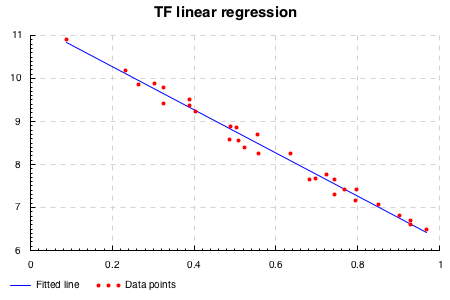

In [28]:
import Data.Colour
import Data.Colour.Names

setLinesBlue :: PlotLines a b -> PlotLines a b
setLinesBlue = plot_lines_style  . line_color .~ opaque blue

chart = toRenderable layout
  where
    fittedLine = plot_lines_values .~ [[(minimum xData, (minimum xData * w + b)), (maximum xData, (maximum xData * w + b))]]
              $ plot_lines_style  . line_color .~ opaque blue
              $ plot_lines_title .~ "Fitted line"
              $ def

    dataPoints = plot_points_style .~ filledCircles 2 (opaque red)
              $ plot_points_values .~ (zip xData noisyY)
              $ plot_points_title .~ "Data points"
              $ def

    layout = layout_title .~ "TF linear regression"
           $ layout_plots .~ [toPlot fittedLine,
                              toPlot dataPoints]
           $ def

chart